#Predict the excess returns of six ETFs with LSTM

## 1. Libraries and settings ¶

In [1]:
import pandas as pd
import numpy as np
import matplotlib   
import matplotlib.pyplot as plt  # for 畫圖用
from matplotlib.font_manager import FontProperties
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

In [2]:
# 匯入資料
def call_data(data_name):
    data1=pd.read_csv(data_name,index_col=0)
    return data1

# 資料清理 轉換 換位
def preprocess(data):
    data = data.drop(labels=['日期',"更改."],axis=1)
    week_return_mean = data['week_return_mean']
    data.drop(['week_return_mean'], axis=1, inplace = True)
    data.insert(0, 'week_return_mean', week_return_mean)
    data['成交量'] = data['成交量'].map(lambda x: str(x)[:-1])
    for i in range(0, len(data)):
      data.iloc[i,5] = np.float64(data.iloc[i,5])
    data.rename(columns={"收市":"Close","開市":"Open","高":"High","低":"Low","成交量":"Volumn"},inplace=True)
    return data

# 新增交互作用
def AugFeatures(data):
    cols = data.columns
    df = data.copy()
    for i in range(1, len(cols)):
        for j in range(i+1, len(cols)):
            df[cols[i]+cols[j]] = df[cols[i]]*df[cols[j]]
    return df

# 訓練資料維度轉換
def train_PrepData(data, N, K):
    df = pd.DataFrame(data)
    X, Y = [], []
    #N = 20 (timesteps)
    #K = 1 (predict_day)
    for i in range(df.shape[0]-N-K+1):
        a = df[i:(i+N)]
        X.append(a)
        Y.append(np.array(df.iloc[i+N:i+N+K,0]))
    return np.array(X), np.array(Y)

# 測試資料維度轉換
def test_PrepData(data, N, K):
    df = pd.DataFrame(data)
    X = []
    for i in range(df.shape[0]-N-K+2):
        a = df[i:(i+N)]
        X.append(a)
    X = np.float64(X)
    return np.array(X)

# LSTM層(兩層) + 丟棄層 + 全連接層
def buildmodel(N, F, n1, n2, p):

    model = Sequential()

    # 第一層的 LSTM layer
    model.add(LSTM(n1, input_shape=(N, F), return_sequences=True))

    # 第二層的 Dropout layer
    #model.add(Dropout(p))
    
    # 第三層的 LSTM layer
    model.add(LSTM(n2, return_sequences=False))

    # 第四層的 Dropout layer
    model.add(Dropout(p))

    # 第五層的 Fully-Connected layer
    model.add(Dense(1))
        
    model.compile(loss="mse", optimizer="adam")
    return model

# 準備作圖資料
def pred_plot(data1):
  data1.loc['0'] = "2022年3月27日"
  data1['日期'] = data1['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
  Y = data1['日期'].tail(27)
  return Y

## 2. Analyze data 


### 2-1. data discription
> seven types of ETF

1.   Russia
2.   Consumer
3.   Health
4.   Spdr
5.   Vangue
6.   SP

> Each ETF has a duration of 454 days

*   y : Excess Return 
*   x : open, close, high, low, volume, and their interactions (15 variables)

###  2-2. Data Visualize

In [ ]:
# 選擇資料集
choose_data = ['russia.csv','consumer.csv','health.csv','spdr.csv','vangue.csv','SP.csv']
choose_title = ['russia','consumer','health','spdr','vangue','SP']
choose_color = ['#1f77b4','#2ca02c','#d62728','#9467bd','#8c564b','#7f7f7f']

choose_data = choose_data[5]
choose_title = choose_title[5]
choose_color = choose_color[5]

In [ ]:
data1=call_data('russia.csv');
data2=call_data('america.csv')
data3=call_data('consumer.csv');data4=call_data('health.csv')
data5=call_data('spdr.csv');data6=call_data('vangue.csv')
#data7=call_data('VIXY.csv');
data8=call_data('SP.csv')

data1['日期'] = data1['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
data2['日期'] = data2['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
data3['日期'] = data3['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
data4['日期'] = data4['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
data5['日期'] = data5['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
data6['日期'] = data6['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))
data8['日期'] = data8['日期'].apply(lambda _: datetime.strptime(_,"%Y年%m月%d日"))

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(data1['日期'], data1['week_return_mean'], label='russia', color='#1f77b4');plt.title('russia')
#plt.plot(data2['日期'], data2['week_return_mean'], label='america', color='#ff7f0e');plt.title('america')
plt.plot(data3['日期'], data3['week_return_mean'], label='consumer', color='#2ca02c');plt.title('consumer')
plt.plot(data4['日期'], data4['week_return_mean'], label='health', color='#d62728');plt.title('health')
plt.plot(data5['日期'], data5['week_return_mean'], label='spdr', color='#9467bd');plt.title('spdr')
plt.plot(data6['日期'], data6['week_return_mean'], label='vangue', color='#8c564b');plt.title('vangue')
plt.plot(data8['日期'], data8['week_return_mean'], label='SP', color='#7f7f7f');plt.title('S&P')
plt.tight_layout()
plt.ylabel("Excess Return")
plt.axhline(y=0.05,color="gray")
plt.axhline(y=-0.05,color="gray")
plt.title("Six types of ETFs", fontsize=20)
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize = (15,10))
plt.subplot(3, 2, 1);plt.plot(data1['日期'], data1['week_return_mean'], label='russia', color='#1f77b4');plt.title('russia')
#plt.subplot(4, 2, 2);plt.plot(data2['日期'], data2['week_return_mean'], label='america', color='#ff7f0e');plt.title('america')
plt.subplot(3, 2, 2);plt.plot(data3['日期'], data3['week_return_mean'], label='consumer', color='#2ca02c');plt.title('consumer')
plt.subplot(3, 2, 3);plt.plot(data4['日期'], data4['week_return_mean'], label='health', color='#d62728');plt.title('health')
plt.subplot(3, 2, 4);plt.plot(data5['日期'], data5['week_return_mean'], label='spdr', color='#9467bd');plt.title('spdr')
plt.subplot(3, 2, 5);plt.plot(data6['日期'], data6['week_return_mean'], label='vangue', color='#8c564b');plt.title('vangue')
#plt.subplot(4, 2, 7);plt.plot(data7['日期'], data7['week_return_mean'], label='VIXY', color='#e377c2');plt.title('VIXY')
plt.subplot(3, 2, 6);plt.plot(data8['日期'], data8['week_return_mean'], label='SP', color='#7f7f7f');plt.title('S&P')
plt.tight_layout()
plt.show()

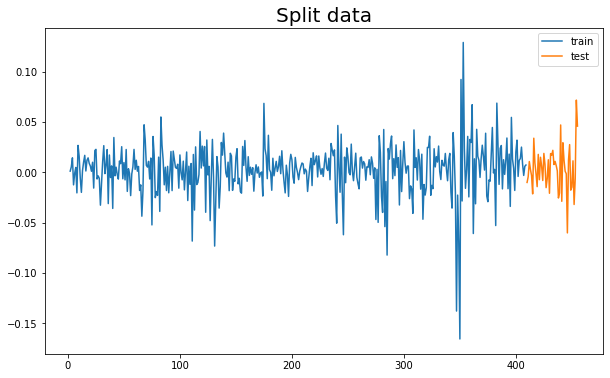

In [ ]:
data1 = call_data(choose_data)
data1 = preprocess(data1)
Aug_data = AugFeatures(data1)
train, test = train_test_split(
    Aug_data, train_size=0.9, shuffle = False
)
plt.figure(figsize=(10, 6))
ax = Aug_data.iloc[:train.shape[0],0].plot()
Aug_data.iloc[train.shape[0]:,0].plot(ax=ax)
plt.title("Split data", fontsize=20)
plt.legend(['train', 'test'])

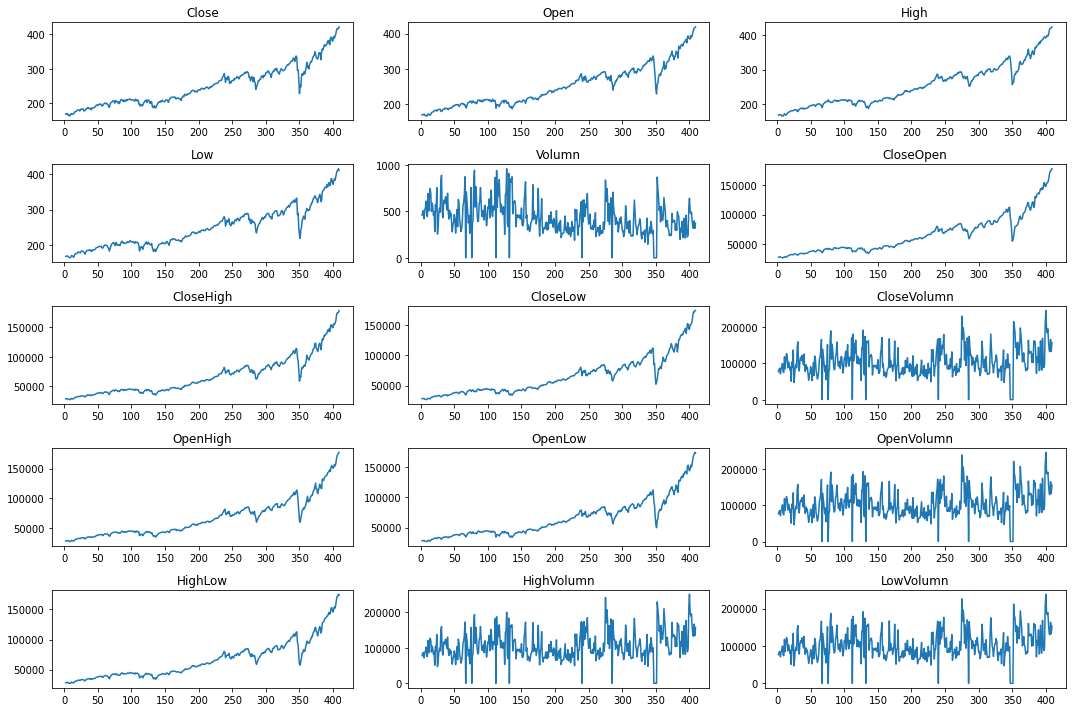

In [ ]:
dim_names = Aug_data.columns[1:]
plt.figure(figsize = (15,10))
for dim in range(train.shape[1]-1):
    plt.subplot(5,3,dim+1)
    plt.plot(train.iloc[:,dim+1])
    plt.title('%s'%(dim_names[dim]))
plt.tight_layout()
plt.show()

## 3. Manipulate data 

In [ ]:
#input data
data1 = call_data(choose_data)

# 資料清理、轉換以及換位
data1 = preprocess(data1)

# 新增變量(交互作用)
Aug_data = AugFeatures(data1)

# 分割train set(90%) test set(10%)
train, test = train_test_split(
    Aug_data, train_size=0.9, shuffle = False
)

# 訓練集標準化
X_train = train.iloc[:,1:16]
y_train = train.iloc[:,0]
sc = MinMaxScaler(feature_range=(-1, 1))
X_train = sc.fit_transform(X_train)
train = np.column_stack((y_train,X_train))

# 訓練資料維度轉換
X_train, y_train = train_PrepData(train, 20, 1)

# 測試集標準化
X_test = test.iloc[:,1:16]
y_test = test.iloc[:,0]
sc = MinMaxScaler(feature_range=(-1, 1))
X_test = sc.fit_transform(X_test)
test = np.column_stack((y_test,X_test))

# 訓練資料維度轉換
X_test = test_PrepData(test, 20, 1)


## 4. Model data

#### 4-1. Model introduction

*   Predict the next day with the past 20 days
*   The data set is divided into training set and test set according to the ratio of 9:1
*   The model contains 4 layers:

  1.   LSTM Layer
  2.   LSTM Layer
  3.   Dropout Layer
  4.   Full connected Layer





In [ ]:
# 輸入model參數
temp_set = buildmodel(X_train.shape[1],X_train.shape[2],64,32,0.2)

# 進行訓練
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = temp_set.fit(X_train, y_train, epochs=500, batch_size=128, callbacks=[callback])
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot( history.history["loss"])

## 5. Predictions 

In [ ]:
# 產生預測值
predicted_value = temp_set.predict(X_test)
# 3/27的預測值
predicted_value_3_27 = predicted_value[-1]
print(predicted_value_3_27)


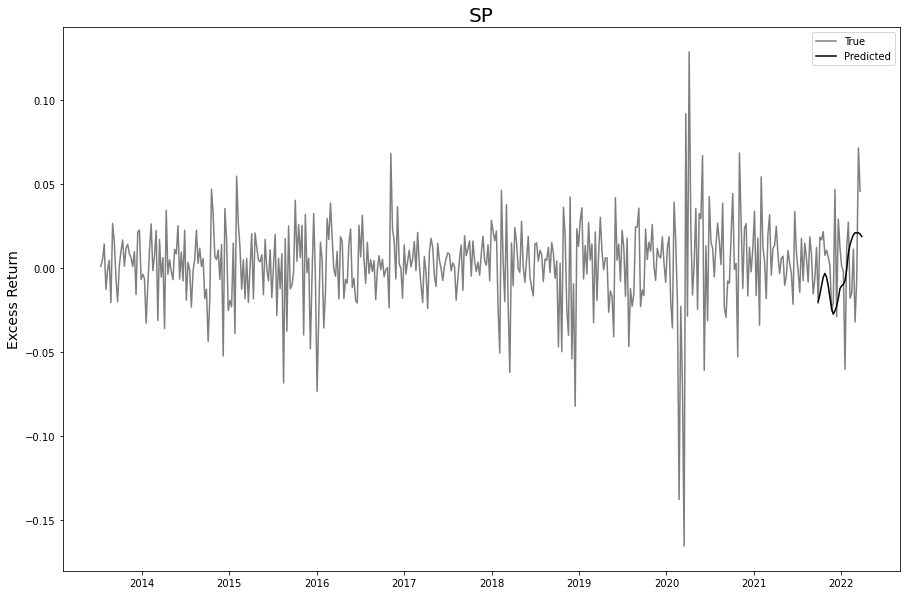

In [ ]:
# 畫出單一的y
data1 = call_data(choose_data)
XX = data1['week_return_mean']
YY = data1['日期'].apply(lambda x: datetime.strptime(x,"%Y年%m月%d日"))
Y = pred_plot(data1)
plt.figure(figsize = (15,10))
plt.plot(YY, XX, color =choose_color, label = 'True')
plt.plot(Y, predicted_value,  color = 'black', label = 'Predicted')
plt.title(choose_title, fontsize=20)
plt.legend(loc='best')
plt.ylabel("Excess Return", fontsize=14)
plt.show()

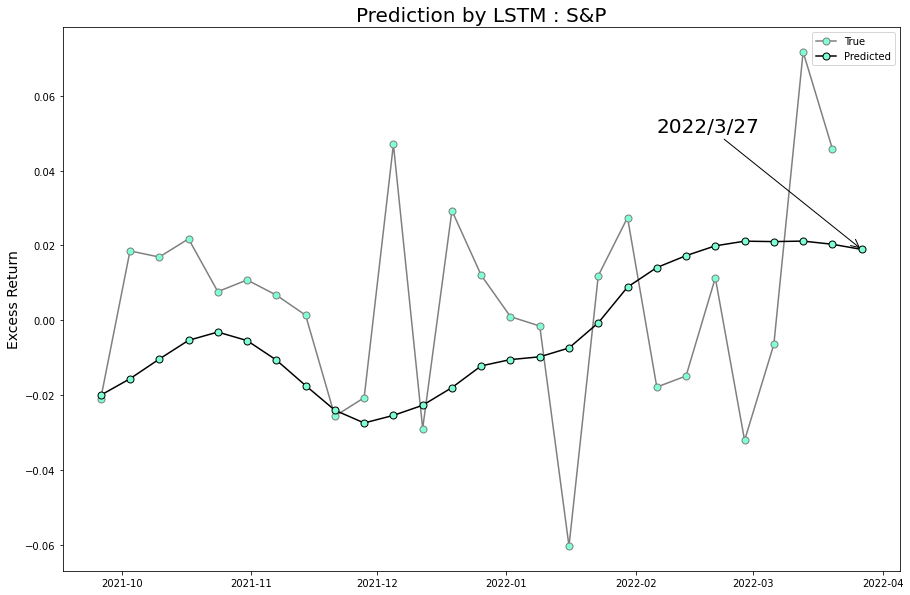

In [ ]:
# 作圖並標記出預測點
data1 = call_data(choose_data)
Y = pred_plot(data1)
true_value = data1.iloc[-27:-1,-1]
plt.figure(figsize = (15,10))
plt.plot(Y[:26], true_value,  color = choose_color, marker = 'o',\
         mfc = 'aquamarine',mec = choose_color, ms =7 \
         , label = 'True')  
plt.plot(Y, predicted_value,  color = 'black', marker = 'o',mfc = 'aquamarine',mec = 'black', ms =7, label = 'Predicted') 
plt.title("Prediction by LSTM : S&P", fontsize=20)
plt.ylabel('Excess Return', fontsize=14)
plt.legend(loc='best')
plt.annotate("2022/3/27",xytext=(Y.iloc[19],predicted_value[25] + 0.03 ),xy=(Y.iloc[26],predicted_value[26]),xycoords='data'\
             ,arrowprops=dict(arrowstyle='->', color='black'), fontsize=20)


plt.show()